In [1]:
import xml.etree.ElementTree as elemTree
import os
import sys
tree = elemTree.parse(r'../config/.config.xml')
root = tree.getroot()
xx = root.find('./PATHS')
work_path = xx.find('work').text
sys.path.append(work_path)

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from tqdm.auto import tqdm
from realtime_kiwoom.data_provider import *

# 주식체결 데이터 실시간 인서트 테스트

In [ ]:
real_data = {'code': '069500', 'type': '주식체결', '20': '100645', '16': '+31345', '17': '+31370', '18': '-31215', '10': ' 31275', '15': '+50', '11': ' 0', '12': '0.00', '13': '1613182'}

In [ ]:
provider = RealTimeTickDataPrivder("kiwoom_db.sqlite3", in_memory_db=True, with_index=True)

connection.execute()로 수행시
- 인덱스 있을 때
  - 10,000건 추가에 70초
- 인덱스 없을 때
  - 10,000건 추가에 65초
- 인메모리
  - 0.7초

dataframe.to_sql()로 수행시
- 인덱스 있을 때
  - 10,000건 추가에 140초
- 인덱스 없을 때
  - 10,000건 추가에 141초
- 인메모리
  - 33초

dataframe.to_sql()로 벌크 수행시 (10,000건)
- 0.7초

결론
- 일정 주기 모아서 인서트 하는게 낫다
- 인메모리 디비로 선택하고, 표준 SQL로 작업하는게 낫다

In [ ]:
for i in range(10000):
  real_data['20'] = f"{i:06d}"
  provider.insert(real_data)

In [ ]:
for i in range(10000):
  real_data['20'] = f"{i:06d}"
  provider.insert_by_dataframe(real_data)

# 주식 체결데이터로부터 분봉 데이터 생성

In [3]:
import re

In [4]:
sample_file_path = r'..\data\주식체결_sample.txt'

In [5]:
p = re.compile(r".*([{]'code.*[}])")

In [6]:
provider = RealTimeTickDataPrivder("kiwoom_db.sqlite3", in_memory_db=True, with_index=True)

In [7]:
with open(sample_file_path, 'r', encoding='utf8') as f:
  for line in f:
    m = p.match(line)
    if m:
      # print(eval(m.group(1)))
      provider.insert(eval(m.group(1)))

In [8]:
provider.engine.execute('select name from sqlite_master where type="table"').fetchall()

[('today_in_ticks',)]

In [9]:
with provider.engine.connect() as connection:
  rr = connection.execute(
  '''
  select DISTINCT t.st_code, t.minute||'00',
  first_value(t.close) over (partition by t.st_code, t.minute order by t.dt ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as open,
  max(t.close) over (partition by t.st_code, t.minute order by t.dt ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as high,
  min(t.close) over (partition by t.st_code, t.minute order by t.dt ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as low,
  last_value(t.close) over (partition by t.st_code, t.minute order by t.dt ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as close
  from (
    select *, substr(dt, 0, 5) as minute from today_in_ticks substr
    ) as t
  '''
  ).fetchall()

In [10]:
df = pd.DataFrame(rr, columns=['code', 'dt', 'open', 'high', 'low', 'close'])

<AxesSubplot:xlabel='dt'>

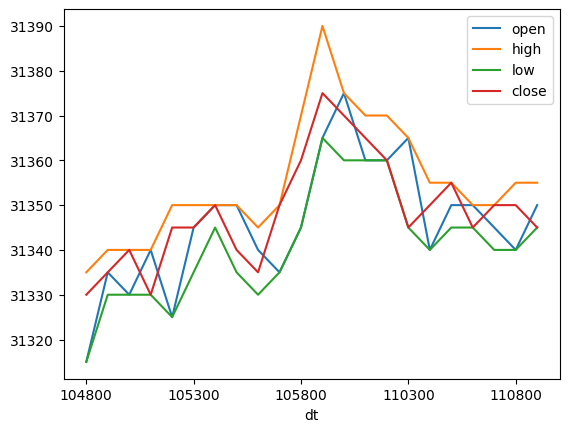

In [11]:
df.query("code=='069500'").plot(x='dt', y=['open', 'high', 'low', 'close'])

In [ ]:
provider.engine.execute('select * from today_in_ticks where st_code="069500"').fetchall()

In [12]:
import plotly.graph_objects as go

In [13]:
fig = go.Figure(data=[go.Candlestick(x=df.query("code=='069500'")['dt'],
                open=df.query("code=='069500'")['open'],
                high=df.query("code=='069500'")['high'],
                low=df.query("code=='069500'")['low'],
                close=df.query("code=='069500'")['close'])])
fig.show()

# 결합 테스트

스태틱 소스
- 어제까지 확보한 분봉 데이터 (TR 요청):: db/kiwoom_db.sqlite3:data_in_minute
- 오늘 장중에 확보한 분봉 데이터 (TR 요청):: db/kiwoom_db.sqlite3:today_in_minute
    - 장해 등으로 장중 (예: 11시)에 재접속 시 생성
        - TR요청으로 수집 

동적 소스
- 오늘 실시간 틱 데이터:: 인메모리 디비:today_in_ticks
- 오늘 틱 데이터로부터 생성한 분봉 데이터:: 인메모리 디비:today_in_minute 

결합
- `정적저장소`:data_in_minute + today_in_minute + `인메모리`:today_in_minute